Minería de Datos

Trabajo Práctico n°2

Integrantes: Lucía Masciangelo, Julieta Texier

Entrega: 29/05/2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn import decomposition, tree, metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier

# Dataset 1: 1000_Companies --> Regresion

In [2]:
df1 = pd.read_csv("1000_Companies.csv")

#### Analisis exploratorio

In [ ]:
df1.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


Vemos que tenemos 5 variables

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


De esas variables 4 son de tipo flotante y 1 es categorica. No se observan valores nulos

In [ ]:
df1.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


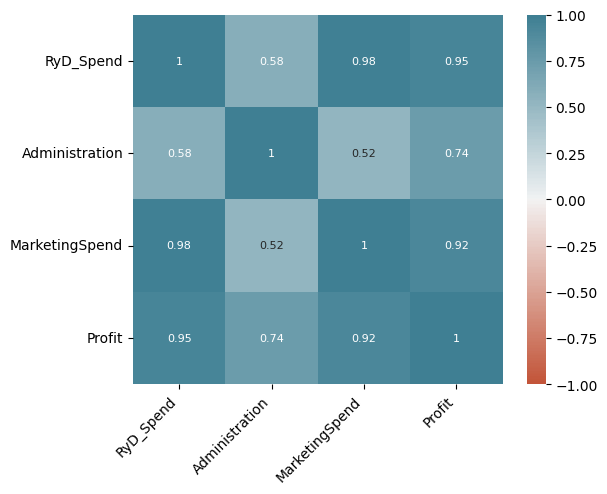

In [ ]:
#Matriz de correlación
corr = df1.drop(['State'], axis=1).corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Casi todas nuestras variables están muy correlacionadas entre si.
Por ejemplo vemos la relación entre MarketingSpend y RyD_Spend

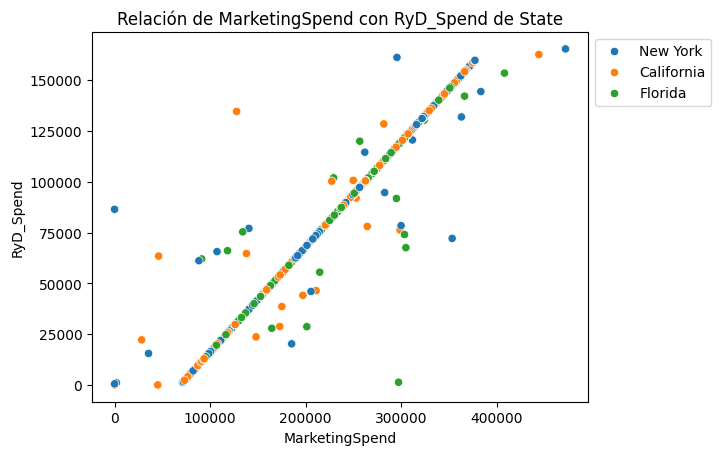

In [ ]:
sns.scatterplot(x='MarketingSpend', y='RyD_Spend', hue='State', data=df1)
plt.xlabel('MarketingSpend')
plt.ylabel('RyD_Spend')
plt.title('Relación de MarketingSpend con RyD_Spend de State')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Observamos una relación lineal positiva entre ambias variables, cuando una aumenta la otra también.
También observamos que no hay un patrón con respecto al estado.



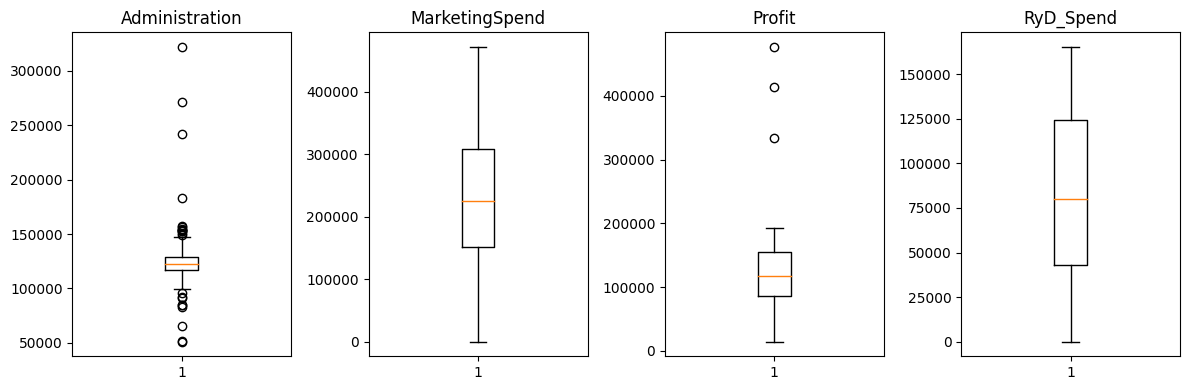

In [ ]:
# Crear una figura y ejes para los boxplots
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# Dibujar los boxplots en cada eje
axes[0].boxplot(df1['Administration'])
axes[0].set_title('Administration')
axes[1].boxplot(df1['MarketingSpend'])
axes[1].set_title('MarketingSpend')
axes[2].boxplot(df1['Profit'])
axes[2].set_title('Profit')
axes[3].boxplot(df1['RyD_Spend'])
axes[3].set_title('RyD_Spend')

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar la gráfica
plt.show()


En la variable Administration vemos que hay muchos outliers y que el 50% de los valores se concentran entre 120000 y 130000.

En Profit también vemos algunos valores atípicos.

Text(0.5, 0, 'Administration')

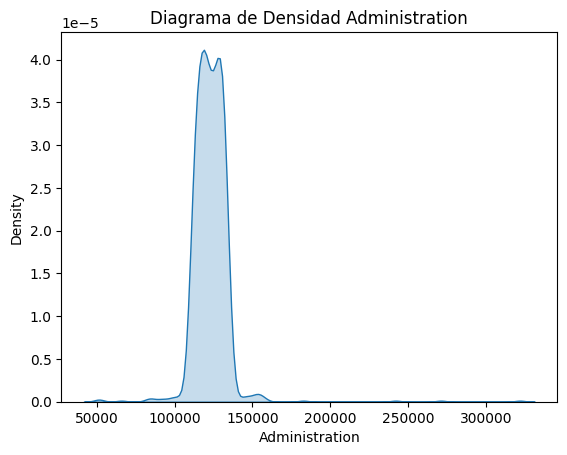

In [ ]:
sns.kdeplot(data=df1['Administration'], fill=True)
plt.title('Diagrama de Densidad Administration')
plt.xlabel('Administration')

Text(0.5, 0, 'Profit')

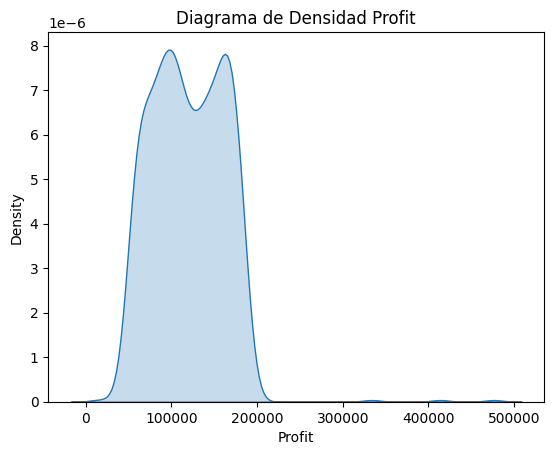

In [ ]:
sns.kdeplot(data=df1['Profit'], fill=True)
plt.title('Diagrama de Densidad Profit')
plt.xlabel('Profit')

La variable que queremos analizar tiene valores outliers además de tener 2 picos en su distribución



##### Estandarización

In [3]:
# Utilizamos el método Z score porque en su fórmula tiene en cuenta la varianza,
# ya que notamos que algunas de nuestras variables tienen una varianza muy alta
df_sub = df1.drop(['State'], axis=1)
df_std = (df_sub-df_sub.mean())/df_sub.std()

Generamos dummies de la variable state

In [4]:
df1['State'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

In [5]:
dummies_state = pd.get_dummies(df1['State'], dtype=int, drop_first=True)
dummies_state = dummies_state.rename(columns={'Florida': 'State_Florida', 'New York': 'State_New_York'})
# df_std = df_std.drop('State', axis=1)
df_std = pd.concat([df_std, dummies_state], axis=1)

In [ ]:
df_std

,RyD_Spend,Administration,MarketingSpend,Profit,State_Florida,State_New_York
0,1.798123,1.104644,2.681626,1.695453,0,1
1,1.738999,2.252565,2.377127,1.684500,0,0
2,1.542250,-1.729703,1.984414,1.667207,1,0
3,1.347373,-0.340263,1.714319,1.477217,0,1
4,1.298702,-2.502958,1.528345,1.087509,1,0
...,...,...,...,...,...,...
995,-0.591649,-0.357692,-0.578438,-0.565796,0,0
996,1.145334,0.588729,1.124708,1.044343,0,0
997,0.399818,9.431037,0.010240,6.864530,0,0
998,1.005366,15.751497,0.605899,4.999367,0,0


In [6]:
# Definimos nuestros conjuntos x e y, donde y es nuestra variable a predecir, y x las variables explicativas
x = df_std.drop(columns=['Profit'])
y = df_std['Profit']

In [7]:
feature_list = list(x.columns)
feature_list

['RyD_Spend',
 'Administration',
 'MarketingSpend',
 'State_Florida',
 'State_New_York']

#### Entrenamiento 80% y Test 20%

In [8]:
#dividimos los datos en entrenamiento (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [9]:
clf = tree.DecisionTreeRegressor(random_state=30)

In [10]:
regressor_tree = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Antes de dibujar el árbol, vamos a optimizar sus hiperparámetros

In [11]:
param_grid = {
    'max_depth': [6, 7, 9],
    'min_samples_split':[2,3,5],
    'min_samples_leaf': [1,2,5],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'], #no usamos poisson pq hay valores negativos
    'random_state': [30]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Mejores hiperparámetros: {'criterion': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'random_state': 30}


In [12]:
clf = tree.DecisionTreeRegressor(max_depth=9,min_samples_leaf=1, min_samples_split=3, criterion = 'squared_error', random_state=30)
#Estos son los Mejores hiperparámetros que obtuvimos con la optimizacion

In [13]:
regressor_tree = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

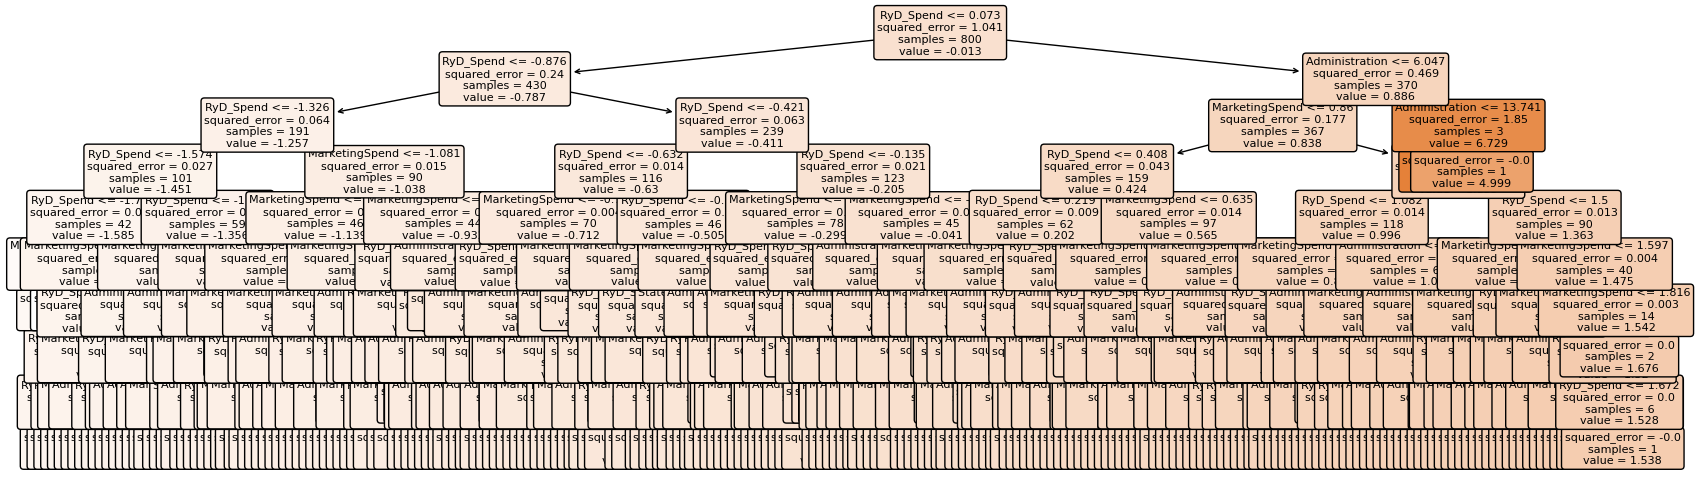

In [14]:
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(regressor_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

Vamos a podar el árbol para poder interpretarlo

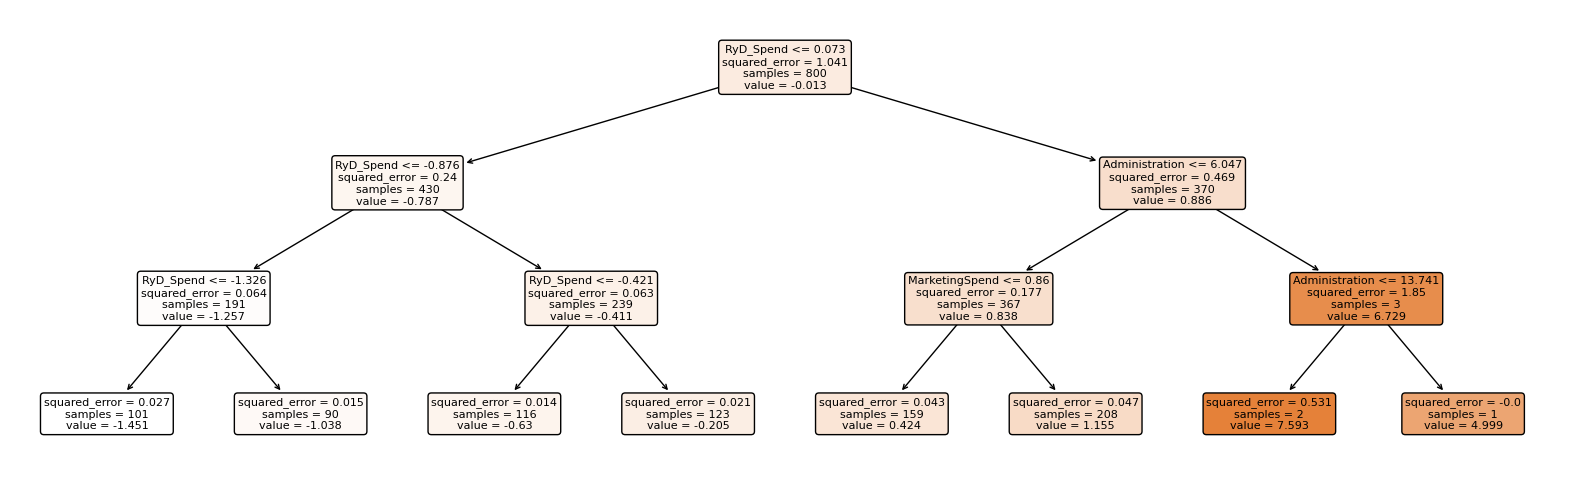

In [15]:
# Podar el árbol en el nivel 4
clf_pruned = tree.DecisionTreeRegressor(max_depth=3,min_samples_leaf=1, min_samples_split=3, criterion = 'squared_error', random_state=30)
clf_pruned.fit(X_train, y_train)

# Graficar el árbol podado
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(clf_pruned,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

# Realizar predicciones sobre el conjunto de datos de prueba
predictions = clf_pruned.predict(X_test)

# Convertir y_test a tipo float si no lo está ya
y_test = y_test.astype(float)

# Calcular métricas de evaluación
mae_pod = mean_absolute_error(y_test, predictions)
mse_pod = mean_squared_error(y_test, predictions)
rmse_pod = np.sqrt(mse_pod)
r2_pod = r2_score(y_test, predictions) # medida de la bondad de ajuste del modelo

# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(feature_list)  # Número de predictores (variables independientes)
r2_adjusted_pod = 1 - ((1 - r2_pod) * (n - 1) / (n - p - 1))  # tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores


**Interpretacion**:

*Nodo Raíz* (Root Node):  En este caso, el nodo raíz tiene la condición RyD_Spend <= 0.073. Esto significa que el conjunto de datos se divide en dos ramas dependiendo de si el valor de RyD_Spend es menor o igual a 0.073 o si es mayor a ese valor.

De los 800 valores que había en el nodo raíz, se dividieron y quedaron 430 de un lado y 370 del otro

*Condiciones de División* (Splitting Conditions):  El segundo nodo a la izquierda del nodo raíz tiene la condición RyD_Spend <= -0.876, lo que significa que los datos en esa rama se dividen de nuevo basándose en si RyD_Spend es menor o igual a -0.876 o mayor a ese valor.


 Metricas

Vamos a calcular las métricas para ambos árboles (el que está podado y el que está sin podar), para poder observar si hay algún cambio o si baja el rendimiento cuando lo podamos.

In [ ]:
y_test = y_test.astype(float)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, predictions) # medida de la bondad de ajuste del modelo

# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(feature_list)  # Número de predictores (variables independientes)
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores

# Imprimimos las métricas
print("Métricas del árbol sin podar: ")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("R-squared adjusted (R2 ajustado):", r2_adjusted)


print("----------------------------------------------------------")
# Imprimir métricas
print("Metricas del árbol podado: ")
print("Mean Absolute Error (MAE):", mae_pod)
print("Mean Squared Error (MSE):", mse_pod)
print("Root Mean Squared Error (RMSE):", rmse_pod)
print("R-squared (R2):", r2_pod)
print("R-squared adjusted (R2 ajustado):", r2_adjusted_pod)

Métricas del árbol sin podar: 
Mean Absolute Error (MAE): 0.1485153434348379
Mean Squared Error (MSE): 0.03303581580869082
Root Mean Squared Error (RMSE): 0.18175757428148853
R-squared (R2): 0.9600271324649889
R-squared adjusted (R2 ajustado): 0.9589969039202721
----------------------------------------------------------
Metricas del árbol podado: 
Mean Absolute Error (MAE): 0.1485153434348379
Mean Squared Error (MSE): 0.03303581580869082
Root Mean Squared Error (RMSE): 0.18175757428148853
R-squared (R2): 0.9600271324649889
R-squared adjusted (R2 ajustado): 0.9589969039202721


Podemos observar que las métricas del árbol no cambian si el árbol está podado o no.

Observando los valores de las métricas podemos decir que el modelo tiene un buen desempeño, ya que todas son bajas.

Es decir que las diferencias entre los valores reales y los predichos por el modelo no son grandes.

comparamos los valores reales con los que predijo el modelo para poder observar que las diferencias entre ellos son bajas.

In [ ]:
tableResult = pd.DataFrame({'Actual':y_test, 'Predicted':predictions})
tableResult

,Actual,Predicted
923,-0.604817,-0.629919
921,-0.535459,-0.629919
516,0.375289,0.423774
87,-0.386008,-0.204929
879,-1.329364,-1.451332
...,...,...
711,0.576868,0.423774
517,-0.650251,-0.629919
984,0.450224,0.423774
886,-0.068622,-0.204929


#### Entrenamiento 70% y Test 30%

In [16]:
#dividimos los datos en entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)

In [17]:
clf = tree.DecisionTreeRegressor(random_state=30)

In [18]:
regressor_tree = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Antes de dibujar el árbol, vamos a optimizar sus hiperparámetros

In [19]:
param_grid = {
    'max_depth': [6,7,9],
    'min_samples_split':[2,3,5],
    'min_samples_leaf': [1,2,5],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'], #no usamos poisson pq hay valores negativos
    'random_state': [30]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Mejores hiperparámetros: {'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 30}


In [20]:
clf = tree.DecisionTreeRegressor(max_depth=9,min_samples_leaf=1, min_samples_split=5, criterion = 'absolute_error', random_state=30)
#Estos son los Mejores hiperparámetros que obtuvimos con la optimizacion

In [21]:
regressor_tree = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

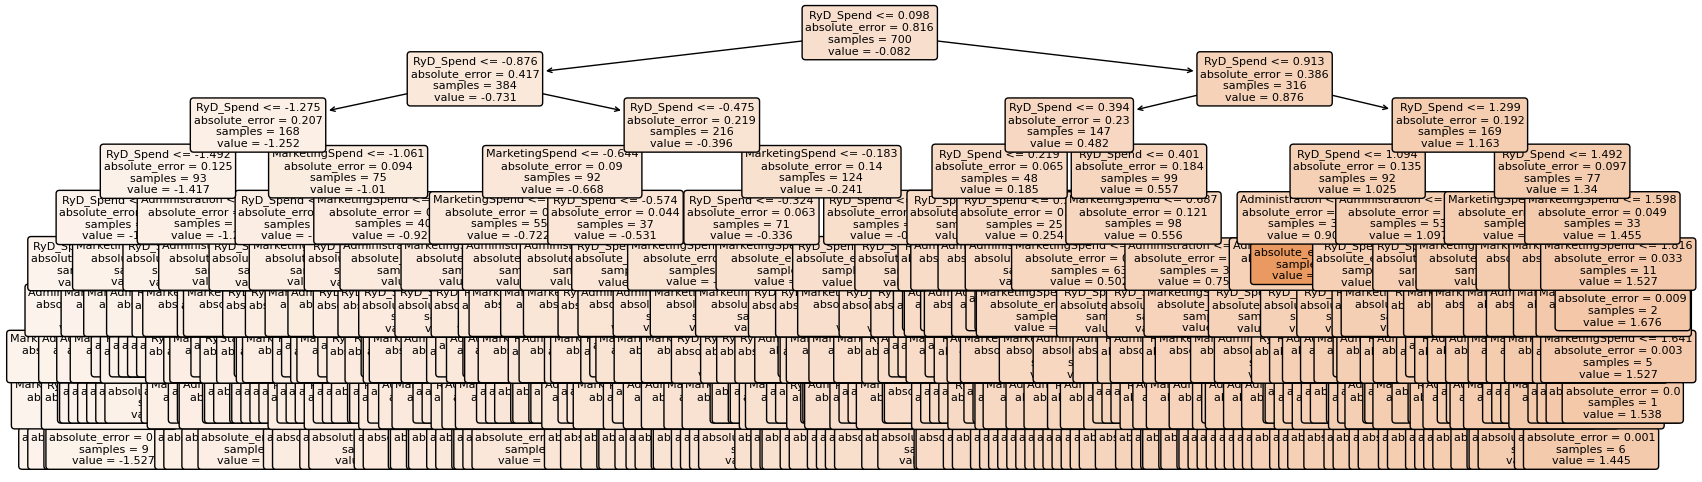

In [22]:
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(regressor_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

podamos el árbol para interpretarlo

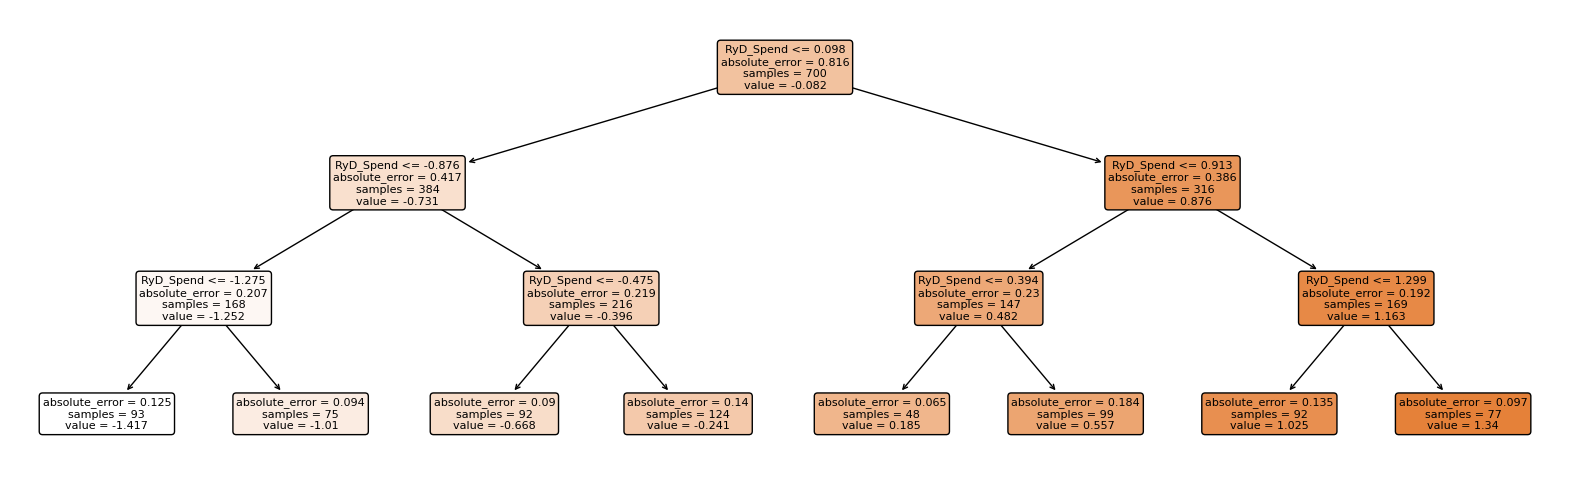

In [23]:
# Podar el árbol en el nivel 4
clf_pruned = tree.DecisionTreeRegressor(max_depth=3,min_samples_leaf=1, min_samples_split=5, criterion = 'absolute_error', random_state=30)
clf_pruned.fit(X_train, y_train)

# Graficar el árbol podado
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(clf_pruned,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

# Realizar predicciones sobre el conjunto de datos de prueba
predictions = clf_pruned.predict(X_test)

# Convertir y_test a tipo float si no lo está ya
y_test = y_test.astype(float)

# Calcular métricas de evaluación
mae_pod = mean_absolute_error(y_test, predictions)
mse_pod = mean_squared_error(y_test, predictions)
rmse_pod = np.sqrt(mse_pod)
r2_pod = r2_score(y_test, predictions) # medida de la bondad de ajuste del modelo

# Calcular R-squared adjusted (R2 ajustado)
n = len(y_test)  # Número de observaciones
p = len(feature_list)  # Número de predictores (variables independientes)
r2_adjusted_pod = 1 - ((1 - r2_pod) * (n - 1) / (n - p - 1))  # tiene en cuenta la complejidad del modelo al penalizar el uso excesivo de predictores

**Interpretacion:**

Nodo Raíz (Root Node): En este caso, el nodo raíz tiene la condición RyD_Spend <= 0.098. Esto significa que el conjunto de datos se divide en dos ramas dependiendo de si el valor de RyD_Spend es menor o igual a 0.098 o si es mayor a ese valor.

En este caso teníamos 700 valores en el nodo raíz y quedaron 384 con un valor de HP menor o igual a 0.098 y 316 con un valor mayor.

Condiciones de División (Splitting Conditions): El segundo nodo a la izquierda del nodo raíz tiene la condición RyD_Spend <= -0.876, lo que significa que los datos en esa rama se dividen de nuevo basándose en si RyD_Spend es menor o igual a -0.876 o mayor a ese valor.

Métricas

In [ ]:
# Imprimir métricas
print("Metricas del árbol podado: ")
print("Mean Absolute Error (MAE):", mae_pod)
print("Mean Squared Error (MSE):", mse_pod)
print("Root Mean Squared Error (RMSE):", rmse_pod)
print("R-squared (R2):", r2_pod)
print("R-squared adjusted (R2 ajustado):", r2_adjusted_pod)

Metricas del árbol podado: 
Mean Absolute Error (MAE): 0.12685949722729523
Mean Squared Error (MSE): 0.1788211389918982
Root Mean Squared Error (RMSE): 0.42287248549875905
R-squared (R2): 0.8371690574577378
R-squared adjusted (R2 ajustado): 0.8338346354261557


Tenemos en cuenta sólo las métricas del árbol podado, ya que en el caso anterior nos dieron exactamente iguales, por lo que suponemos que en este caso tambien

Si comparamos los 2 tamaños distintos de test podemos decir que vemos diferencias entre usar 20% o 30% para probar el rendimiento del modelo. Cuando tenemos un tamaño de 20% las métricas son mejores ya que son mas bajas y el R2 ajustado es mas alto, es decir que el modelo ajusta mejor.


# Dataset 2: PokemonDB

## Clasificación

In [ ]:
df2 = pd.read_csv('PokemonDB.csv')

#### Analisis exploratorio

In [ ]:
df2.head()

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,45,49,49,65,65,45
1,Ivysaur,Grass,60,62,63,80,80,60
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
4,Charmander,Fire,39,52,43,60,50,65


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1190 non-null   object
 1   Type     1190 non-null   object
 2   HP       1190 non-null   int64 
 3   Attack   1190 non-null   int64 
 4   Defense  1190 non-null   int64 
 5   Sp. Atk  1190 non-null   int64 
 6   Sp. Def  1190 non-null   int64 
 7   Speed    1190 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.5+ KB


Podemos ver que tenemos 8 variables, de las cuales 2 son categóricas y el resto son numericas (discretas).
Tambien observamos que no tenemos valores nulos.

In [ ]:
df2.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,70.852941,80.957983,74.586555,72.756303,72.050420,69.695798
std,26.886443,32.119650,30.718212,32.658636,27.637522,30.204376
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,51.250000,56.000000,51.000000,50.000000,50.000000,45.000000
50%,70.000000,80.000000,70.000000,65.000000,70.000000,67.000000
75%,85.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000


In [ ]:
df2.duplicated().sum()

29

Aca podemos observar que tenemos 29 filas que están diplicadas. Procedemos a eliminarlas

In [ ]:
df2.drop_duplicates(inplace =True)

##### Graficos

Verificamos si el dataset está balanceado.

In [ ]:
df2['Type'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark', 'Poison',
       'Electric', 'Ground', 'Ice', 'Fairy', 'Steel', 'Fighting',
       'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying'], dtype=object)

In [ ]:
df2['Type'].value_counts()

Type
Water       146
Normal      126
Grass       104
Bug          89
Psychic      81
Fire         75
Electric     65
Rock         63
Dark         56
Dragon       47
Ghost        47
Ground       46
Fighting     46
Ice          43
Steel        43
Poison       43
Fairy        31
Flying       10
Name: count, dtype: int64

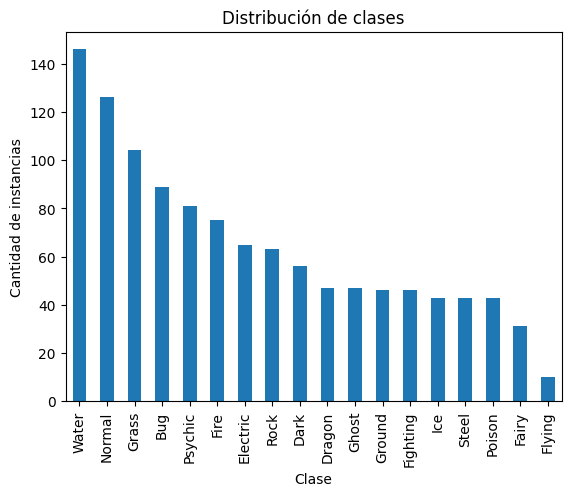

In [ ]:
df2['Type'].value_counts().plot(kind='bar')
plt.xlabel('Clase')
plt.ylabel('Cantidad de instancias')
plt.title('Distribución de clases')
plt.show()

Aca podemos ver que tenemos estas clases: 'Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark', 'Poison', 'Electric', 'Ground', 'Ice', 'Fairy', 'Steel', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying', y nos dimos cuenta que no están balanceados

Realizamos la matriz de correlación

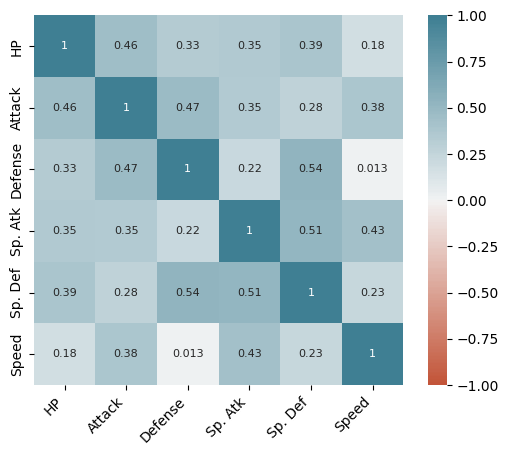

In [ ]:
corr = df2.drop(['Type', 'Name'], axis=1).corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Observamos que ninguna de las variables está muy fuertemente correlacionada linealmente, pero todas están correlacionadas de forma positiva.

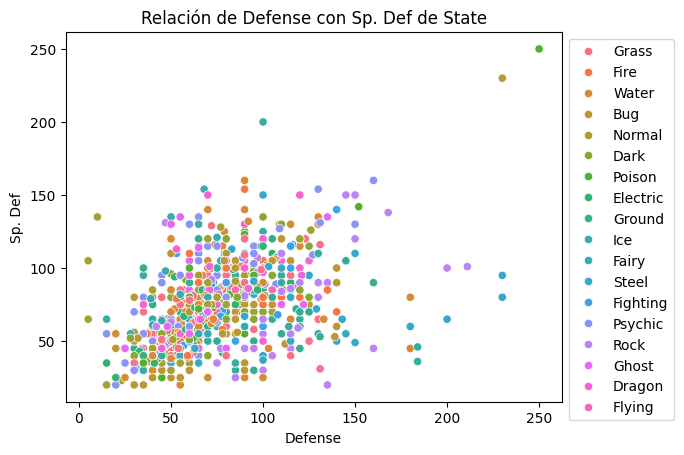

In [ ]:
# Variables con correlacion mas alta (0.54)
sns.scatterplot(x='Defense', y='Sp. Def', hue='Type', data=df2)
plt.xlabel('Defense')
plt.ylabel('Sp. Def')
plt.title('Relación de Defense con Sp. Def de State')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

como vimos en la matriz de correlación no se detecta ningún patrón lineal entre estas variables

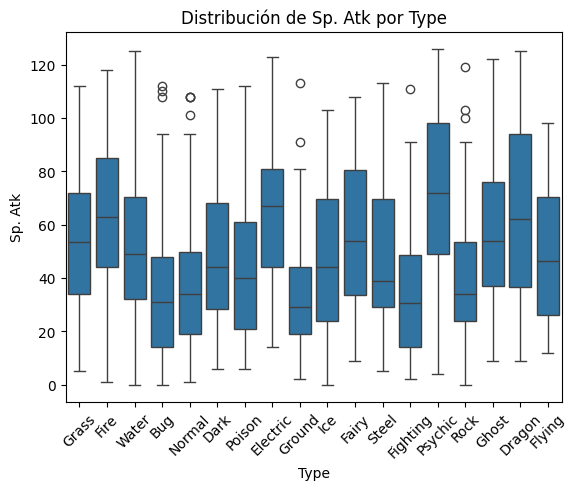

In [ ]:
# Boxplot de la variable Defense con respecto a Type
sns.boxplot(x='Type', y='Sp. Atk', data=df2)
plt.xlabel('Type')
plt.ylabel('Sp. Atk')
plt.title('Distribución de Sp. Atk por Type')
plt.xticks(rotation=45)
plt.show()

Notamos diferencias entre las distintas categorías con respecto a la variable Sp. Atk.

### Árbol de decisión

No vamos a generar dummies de las  variables Type y Name porque la variable Type es la que nosotros queremos predecir, y la variable Name tiene 1008 valores distintos, o sea, que cada pokemon tiene un nombre distinto (exceptuando algunos que se repiten). Asi que a partir de ahora vamos a utilizar el datset df2

In [ ]:
tipos_pokemon = df2['Type'].unique()
tipos_pokemon

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark', 'Poison',
       'Electric', 'Ground', 'Ice', 'Fairy', 'Steel', 'Fighting',
       'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying'], dtype=object)

In [ ]:
df2['Type'].value_counts()

Type
Water       146
Normal      126
Grass       104
Bug          89
Psychic      81
Fire         75
Electric     65
Rock         63
Dark         56
Dragon       47
Ghost        47
Ground       46
Fighting     46
Ice          43
Steel        43
Poison       43
Fairy        31
Flying       10
Name: count, dtype: int64

In [ ]:
df2['Name'].value_counts()

Name
Castform      4
Oricorio      4
Gourgeist     4
Darmanitan    4
Pumpkaboo     4
             ..
Turtwig       1
Grotle        1
Torterra      1
Chimchar      1
Miraidon      1
Name: count, Length: 1008, dtype: int64

#### División en train-test

vamos a probar con 2 divisiones diferentes, 80 entrenamiento 20 prueba y 70 entrenamiento 30 prueba

#### 80% entrenamiento y 20% prueba

In [ ]:
df3_train, df3_test,  = train_test_split(df2, test_size=0.2, random_state=12)

In [ ]:
#verificamos si quedaron todas las categorías en la división de test
etiquetas = df3_test['Type'].unique()
etiquetas

array(['Normal', 'Ground', 'Bug', 'Steel', 'Electric', 'Water', 'Fire',
       'Ghost', 'Psychic', 'Rock', 'Fairy', 'Dark', 'Dragon', 'Ice',
       'Poison', 'Fighting', 'Grass'], dtype=object)

vemos que tiene una categoría menos, que se debe a que mis datos están desbalanceados.

In [ ]:
# Extraer las etiquetas (variable objetivo) de la columna 'Type' en los DataFrames 'df_train' y 'df_test', y convertirlas en arreglos NumPy.
train_labels = np.array(df3_train['Type'])
test_labels = np.array(df3_test['Type'])

# Elimino las etiquetas para separar las características (variables independientes) de la variable objetivo.
# Elimino la variable Name porque no la puedo utilizar en el arbol (variable categorica)
df_train = df3_train.drop(['Type', 'Name'], axis = 1)
df_test = df3_test.drop(['Type', 'Name'], axis = 1)

# Lista de nombres de características extrayendo los nombres de columna del DataFrame 'df_train' para usarlos luego.
feature_list = list(df_train.columns)

# Convierte los DataFrames modificados (sin la columna 'Type') es decir, las características (variables independientes) a array.
train_features = np.array(df_train)
test_features = np.array(df_test)

In [ ]:
clf = tree.DecisionTreeClassifier(random_state = 12)

In [ ]:
#Entreno el modelo pasando las características de entrenamiento (train_features) y las etiquetas de entrenamiento correspondientes (train_labels).
decision_tree = clf.fit(train_features, train_labels)

# Predicción en el conjunto de entrenamiento
clf_predictions_train = clf.predict(train_features)

# Predicción en el conjunto de prueba
clf_predictions = clf.predict(test_features)

Vamos a evaluar el accuracy en el conjunto de entrenamieto y en de test, porque si tiene un valor muy alto en train y una bajo en test puede ser que este overfitteando

In [ ]:
#Evaluo el rendimiento del modelo
train_accuracy = accuracy_score(train_labels, clf_predictions_train)
test_accuracy = accuracy_score(test_labels, clf_predictions)
print('Accuracy en train: ', train_accuracy)
print('Accuracy en test: ', test_accuracy)

Accuracy en train:  0.9741379310344828
Accuracy en test:  0.12446351931330472


Claramente hay overfitting porque el accuracy del train es mucho mas grande que el de test, para corregir un poco eso aplicamos la optimización de hiperparámetros

Optimizacion de hiperparámetros

In [ ]:
# max_depth: La profundidad máxima del árbol.
# min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
# min_samples_leaf: Número mínimo de observaciones en un nodo hoja (por separación)
# criterion: Criterio de separación ('gini' o 'entropy')
# random_state: Semilla para la generación de números aleatorios.

param_grid = {
    'max_depth': [6,7, 9, 10],
    'min_samples_split':[2,4],
    'min_samples_leaf': [2,5,10],
    'criterion': ['gini', 'entropy'],
    'random_state': [12]
}
#usamos grid search pq en este caso tarda muy poco y nos aseguramos de llegar al optimo global
grid_search = GridSearchCV(tree.DecisionTreeClassifier(),
                                   param_grid)
grid_search.fit(train_features, train_labels)
first_best_params = grid_search.best_params_ # Mejores hiperparámetros encontrados durante la búsqueda aleatoria

best_prediction = grid_search.predict(test_features) #Entrenamos el modelo con estos hiperparametros

test_accuracy = accuracy_score(test_labels, best_prediction)

print(f'{first_best_params} \n {test_accuracy}')

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 12} 
 0.19313304721030042


 Implementación de la tecnica

In [ ]:
clf = tree.DecisionTreeClassifier(
    max_depth=6,             # Profundidad máxima del árbol
    min_samples_split=2,      # Número mínimo de observaciones para dividir un nodo
    min_samples_leaf=2,       # Número mínimo de observaciones en un nodo hoja
    criterion='gini',         # Criterio de separación ('gini' o 'entropy')
    random_state = 12
)
#estos son los hiperparámetros que obtuvimos en la optimizacion

In [ ]:
#Entreno el modelo pasando las características de entrenamiento (train_features) y las etiquetas de entrenamiento correspondientes (train_labels).
decision_tree = clf.fit(train_features, train_labels)

# Predicción en el conjunto de entrenamiento
clf_predictions_train = clf.predict(train_features)

# Predicción en el conjunto de prueba
clf_predictions = clf.predict(test_features)

Vemos la importancia de cada atributo

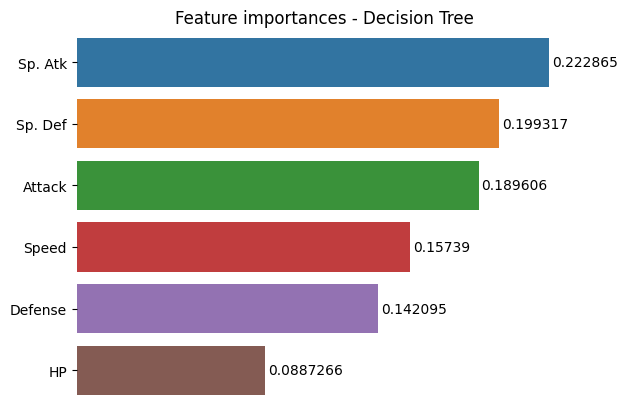

In [ ]:
#Creamos un DF con dos columnas -> Caracteristica y ganacia de informacion
features_df = pd.DataFrame({'features': feature_list, 'importances': decision_tree.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features', hue ='features', legend=False)
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

vemos que la variable Sp. Atk es un poco mas importante que las otras

Árbol de decisión

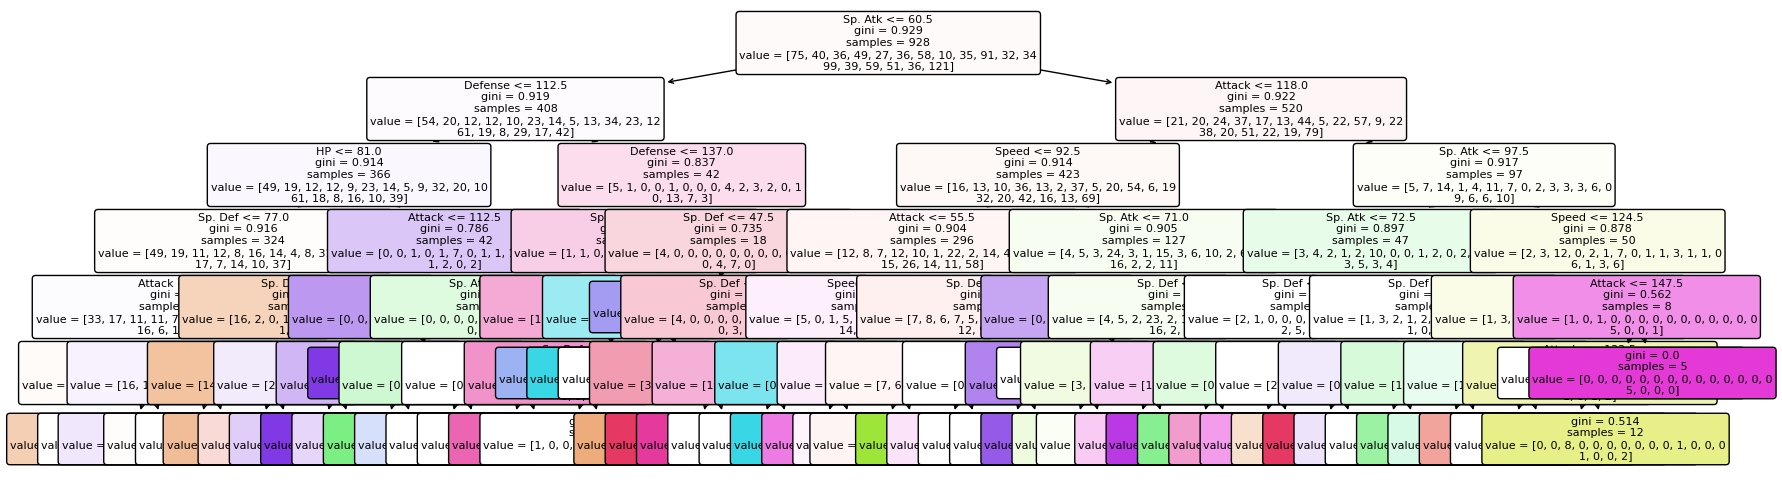

In [ ]:
features = feature_list # Nombres de cada columna
plt.figure(figsize=(20,6))
tree.plot_tree(decision_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

Podamos el árbol

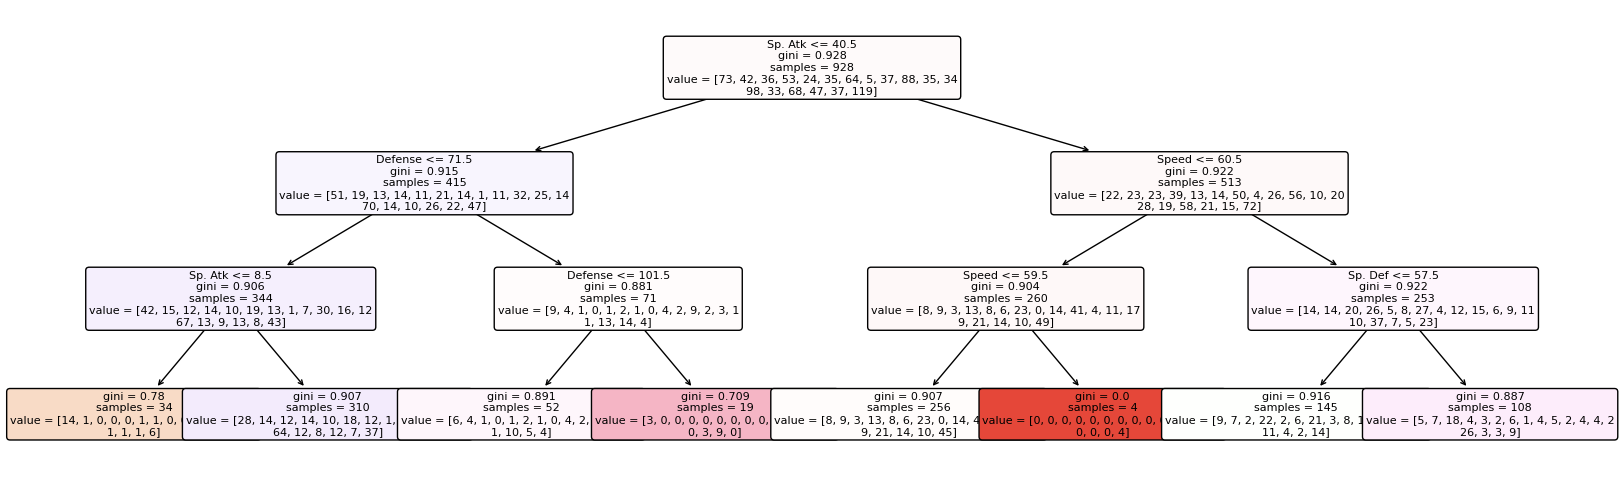

In [ ]:
# Podar el árbol en el nivel 4
clf_pruned = tree.DecisionTreeClassifier(
    max_depth=3,             # Profundidad máxima del árbol
    min_samples_split=2,      # Número mínimo de observaciones para dividir un nodo
    min_samples_leaf=2,       # Número mínimo de observaciones en un nodo hoja
    criterion='gini',         # Criterio de separación ('gini' o 'entropy')
    random_state = 12
)
clf_pruned.fit(X_train, y_train)

# Graficar el árbol podado

features = feature_list # Nombres de cada columna
plt.figure(figsize=(20,6))
tree.plot_tree(clf_pruned,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()


Este árbol con los parámetros elegidor por GridSearch y una profundidad de 3, generó 8 hojas, es decir 8 clusters, de los cuales uno tiene gini = 0 lo que implica que ese cluster es puro, solo tiene 4 valores de la misma categoría.

Métricas

In [ ]:
accuracy = accuracy_score(test_labels, clf_predictions)
precision = precision_score(test_labels, clf_predictions, average='weighted', zero_division=0)
recall = recall_score(test_labels, clf_predictions, average='weighted')
confusion = confusion_matrix(test_labels, clf_predictions)
print(f'Accuracy: {accuracy}')
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.19313304721030042
Precision: 0.13691301207291792
Recall: 0.19313304721030042


El modelo clasifica correctamente el 19% de mis datos de prueba

<Figure size 800x600 with 0 Axes>

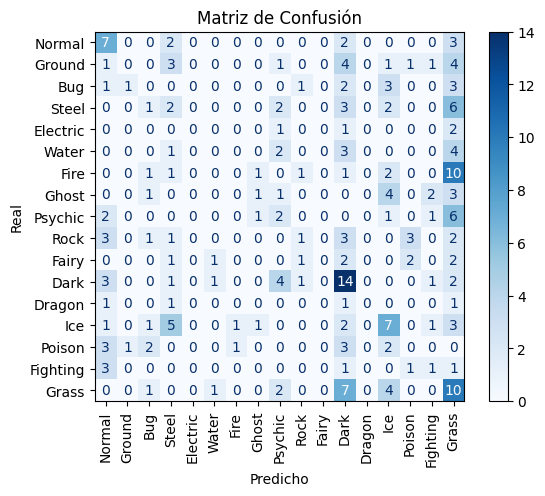

In [ ]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=etiquetas)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Matriz de Confusión")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

En la matriz de confusión podemos ver que hay 4 categorías (Normal, Grass, Dark y Ice) que fueron mejor clasificadas. También vemos que falta la categoría Flying ya que no tenía ningún valor en nuestro conjunto de prueba.

#### 70% entrenamiento y 30% prueba

In [ ]:
df2_train, df2_test,  = train_test_split(df2, test_size=0.3, random_state=12)

In [ ]:
#verificamos si quedaron todas las categorías en la división de test
etiquetas = df3_test['Type'].unique()
etiquetas

array(['Normal', 'Ground', 'Bug', 'Steel', 'Electric', 'Water', 'Fire',
       'Ghost', 'Psychic', 'Rock', 'Fairy', 'Dark', 'Dragon', 'Ice',
       'Poison', 'Fighting', 'Grass'], dtype=object)

En este caso también vemos que falta la etiqueta Flying

In [ ]:
# Extraer las etiquetas (variable objetivo) de la columna 'Type' en los DataFrames 'df_train' y 'df_test', y convertirlas en arreglos NumPy.
train_labels = np.array(df2_train['Type'])
test_labels = np.array(df2_test['Type'])

# Elimino las etiquetas para separar las características (variables independientes) de la variable objetivo.
# Elimino la variable Name porque no la puedo utilizar en el arbol (variable categorica)
df_train = df2_train.drop(['Type', 'Name'], axis = 1)
df_test = df2_test.drop(['Type', 'Name'], axis = 1)

# Lista de nombres de características extrayendo los nombres de columna del DataFrame 'df_train' para usarlos luego.
feature_list = list(df_train.columns)

# Convierte los DataFrames modificados (sin la columna 'Type') es decir, las características (variables independientes) a array.
train_features = np.array(df_train)
test_features = np.array(df_test)

 Aplicacion de la tecnica

In [ ]:
clf = tree.DecisionTreeClassifier(random_state = 12)

In [ ]:
#Entreno el modelo pasando las características de entrenamiento (train_features) y las etiquetas de entrenamiento correspondientes (train_labels).
decision_tree = clf.fit(train_features, train_labels)

# Predicción en el conjunto de entrenamiento
clf_predictions_train = clf.predict(train_features)

# Predicción en el conjunto de prueba
clf_predictions = clf.predict(test_features)

Vamos a evaluar el accuracy en el conjunto de entrenamieto y en de test, porque si tiene un valor muy alto en train y una bajo en test puede ser que este overfitteando

In [ ]:
#Evaluo el rendimiento del modelo
train_accuracy = accuracy_score(train_labels, clf_predictions_train)
test_accuracy = accuracy_score(test_labels, clf_predictions)
print('Accuracy en train: ', train_accuracy)
print('Accuracy en test: ', test_accuracy)

Accuracy en train:  0.9741379310344828
Accuracy en test:  0.14040114613180515


tiene overfitting ya que el accuracy en train es mayor que en test, para mejorar esto vamos a ajustar los hiperparámetros

Optimización de hiperparámetros

In [ ]:
# max_depth: La profundidad máxima del árbol.
# min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.
# min_samples_leaf: Número mínimo de observaciones en un nodo hoja (por separación)
# criterion: Criterio de separación ('gini' o 'entropy')
# random_state: Semilla para la generación de números aleatorios.

#este no lo pide
# max_features: El número máximo de características a considerar para cada división. Suele ser la raíz cuadrada del número de características.

param_grid = {
    'max_depth': [6, 9, 10],
    'min_samples_split':[2,4],
    'min_samples_leaf': [1,2,4,],
    'criterion': ['gini', 'entropy'],
    'random_state': [12]
}
#usamos grid search pq en este caso tarda muy poco y nos aseguramos de llegar al optimo global
grid_search = GridSearchCV(tree.DecisionTreeClassifier(),
                                   param_grid)
grid_search.fit(train_features, train_labels)
first_best_params = grid_search.best_params_ # Mejores hiperparámetros encontrados durante la búsqueda aleatoria

best_prediction = grid_search.predict(test_features) #Entrenamos el modelo con estos hiperparametros

test_accuracy = accuracy_score(test_labels, best_prediction)

print(f'{first_best_params} \n {test_accuracy}')


{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 12} 
 0.1346704871060172


In [ ]:
clf = tree.DecisionTreeClassifier(
    max_depth=6,             # Profundidad máxima del árbol
    min_samples_split=2,      # Número mínimo de observaciones para dividir un nodo
    min_samples_leaf=4,       # Número mínimo de observaciones en un nodo hoja
    criterion='entropy',         # Criterio de separación ('gini' o 'entropy')
    random_state = 12
)

In [ ]:
#Entreno el modelo pasando las características de entrenamiento (train_features) y las etiquetas de entrenamiento correspondientes (train_labels).
decision_tree = clf.fit(train_features, train_labels)

# Predicción en el conjunto de entrenamiento
clf_predictions_train = clf.predict(train_features)

# Predicción en el conjunto de prueba
clf_predictions = clf.predict(test_features)

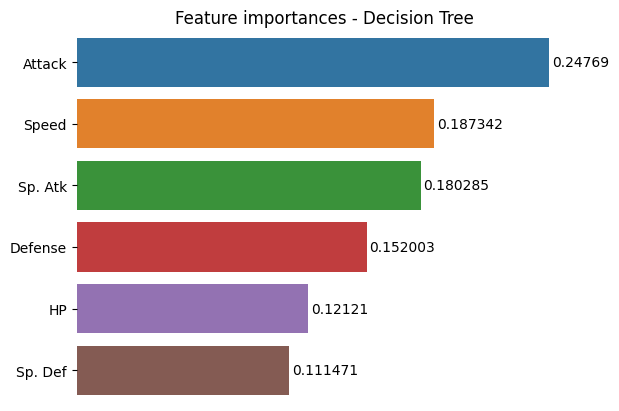

In [ ]:
#Creamos un DF con dos columnas -> Caracteristica y ganacia de informacion
features_df = pd.DataFrame({'features': feature_list, 'importances': decision_tree.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features', hue ='features', legend=False)
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

Podemos ver que las variables Attack, Speed y Sp. atk son un poco mas importantes que las otras

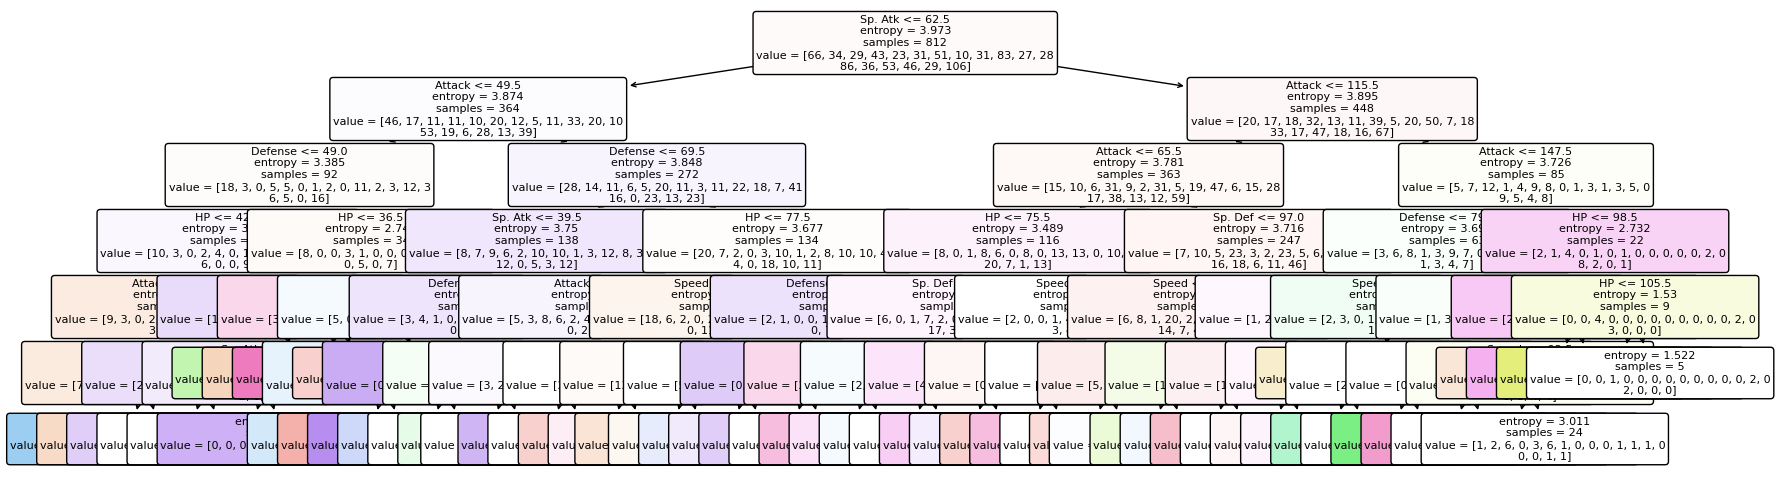

In [ ]:
features = feature_list # Nombres de cada columna
plt.figure(figsize=(20,6))
tree.plot_tree(decision_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()

Podamos el árbol

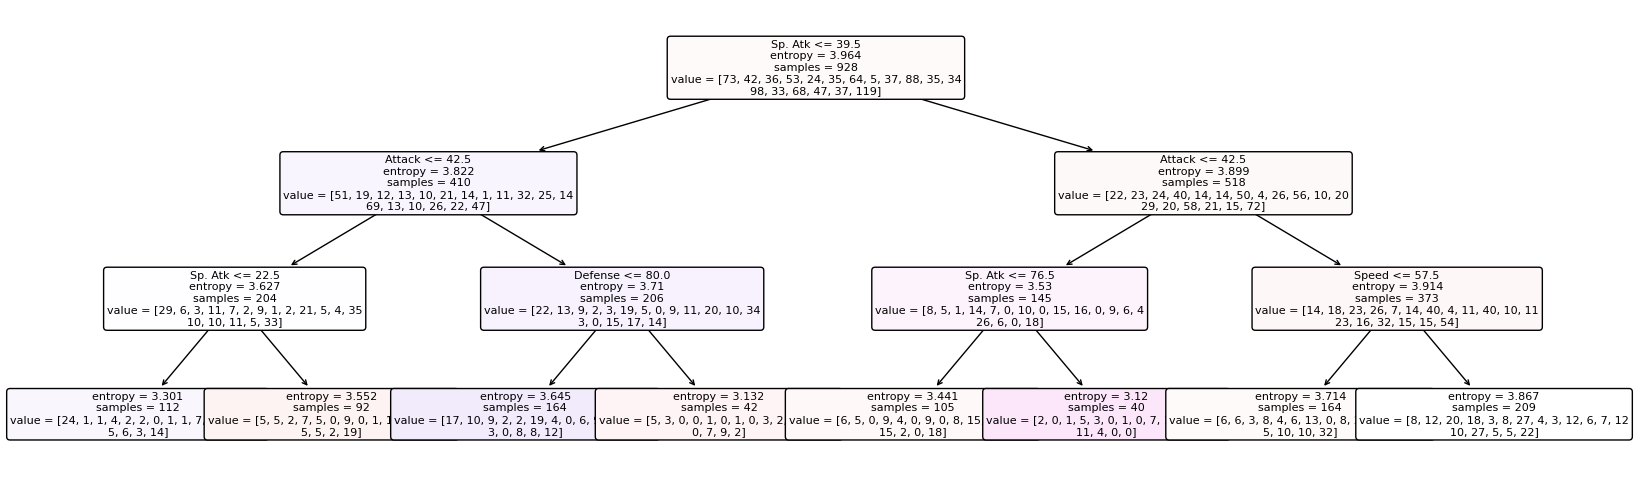

In [ ]:
# Podar el árbol en el nivel 4
clf_pruned = tree.DecisionTreeClassifier(
    max_depth=3,             # Profundidad máxima del árbol
    min_samples_split=2,      # Número mínimo de observaciones para dividir un nodo
    min_samples_leaf=4,       # Número mínimo de observaciones en un nodo hoja
    criterion='entropy',         # Criterio de separación ('gini' o 'entropy')
    random_state = 12
)
clf_pruned.fit(X_train, y_train)

# Graficar el árbol podado

features = feature_list # Nombres de cada columna
plt.figure(figsize=(20,6))
tree.plot_tree(clf_pruned,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)
plt.show()


En este árbol a diferencia del otro utiliza el criterio de entropy,podemos ver que en ninguna de las hojas llegamos a tener una entropia igual a 0, lo que significa que todos mis clusters están mezclados, es decir tienen varias categorías dentro de cada uno.

Métricas

In [ ]:
accuracy = accuracy_score(test_labels, clf_predictions)
precision = precision_score(test_labels, clf_predictions, average='weighted', zero_division=0)
recall = recall_score(test_labels, clf_predictions, average='weighted')
confusion = confusion_matrix(test_labels, clf_predictions)

print(f'Accuracy: {accuracy}')
print('Precision:', precision)
print('Recall:', recall)

#metricas del test de 20%:
#Accuracy: 0.19313304721030042
#Precision: 0.13691301207291792
#Recall: 0.19313304721030042


Accuracy: 0.1346704871060172
Precision: 0.12468779225258203
Recall: 0.1346704871060172


Comparando el accuracy de ambos tamaños de test vemos que el de tamaño 20% es mejor ya que es 0.19 contra 0.13

<Figure size 800x600 with 0 Axes>

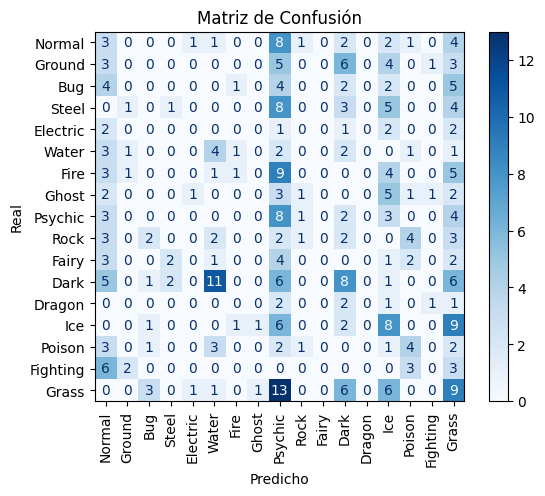

In [ ]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=etiquetas)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Matriz de Confusión")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Las 4 categorías que mas true positive tuvieron en este caso son Grass, Psychic, Ice y Dark.

Podemos decir que el modelo clasificó mal a 13 registros que eran Grass y los clasificó como Psychic.

## Bayes Ingenuo

Discretizamos los atributos con label_encoder

In [ ]:
# Convertir las columnas a categóricas
df2['HP'] = pd.Categorical(df2['HP'])
df2['Attack'] = pd.Categorical(df2['Attack'])
df2['Defense'] = pd.Categorical(df2['Defense'])
df2['Sp. Atk'] = pd.Categorical(df2['Sp. Atk'])
df2['Sp. Def'] = pd.Categorical(df2['Sp. Def'])
df2['Speed'] = pd.Categorical(df2['Speed'])


In [ ]:
# Convertir las columnas categóricas en numéricas

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Aplicar el LabelEncoder a las columnas categóricas
df2['HP'] = label_encoder.fit_transform(df2['HP'])
df2['Attack'] = label_encoder.fit_transform(df2['Attack'])
df2['Defense'] = label_encoder.fit_transform(df2['Defense'])
df2['Sp. Atk'] = label_encoder.fit_transform(df2['Sp. Atk'])
df2['Sp. Def'] = label_encoder.fit_transform(df2['Sp. Def'])
df2['Speed'] = label_encoder.fit_transform(df2['Speed'])

### Split

In [ ]:
X_MN = df2.drop(['Name', 'Type'], axis=1)
y_MN = df2['Type']  # y es la columna 'output'

### Entrenamiento 80% y Prueba 20%

In [ ]:
x_MN_Train, x_MN_Test, y_MN_Train, y_MN_Test = train_test_split(X_MN, y_MN, test_size=0.2, random_state=12)

#### Multinomial Naïve Bayes

In [ ]:
# Definición y Entrenamiento del Modelo
#elegimos multinomial porque consideramos que nuestos atributos son discretos
mnb =  MultinomialNB()
mnb.fit(x_MN_Train, y_MN_Train)

MultinomialNB()

In [ ]:
# Testeo
y_mnb_Pred = mnb.predict(x_MN_Test)

#### Métricas

In [ ]:
# Calcular métricas
precision_mnb = precision_score(y_MN_Test, y_mnb_Pred, average='weighted', zero_division=0)
accuracy_mnb = accuracy_score(y_MN_Test, y_mnb_Pred)
recall_mnb = recall_score(y_MN_Test, y_mnb_Pred, average='weighted', zero_division=0)
cm_mnb = metrics.confusion_matrix(y_MN_Test, y_mnb_Pred)

# Crear una tabla con las métricas
metricas = pd.DataFrame({
    'Precision': [precision_mnb],
    'Accuracy': [accuracy_mnb],
    'Recall': [recall_mnb]
})

print(metricas)

   Precision  Accuracy    Recall
0   0.171903  0.145923  0.145923


El accuracy dio mas bajo que para el árbol de decisión

<Figure size 800x600 with 0 Axes>

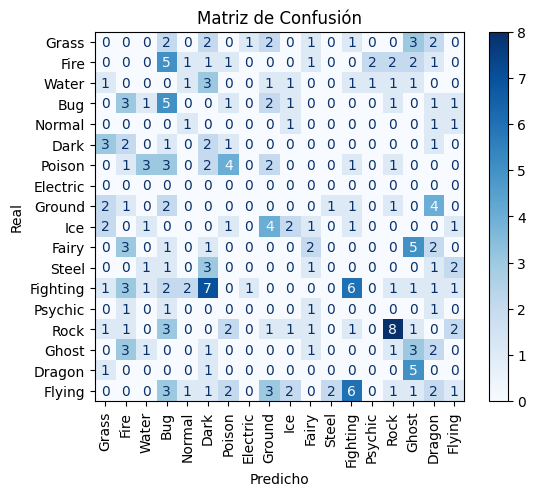

In [ ]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mnb, display_labels=tipos_pokemon)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Matriz de Confusión")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Podemos ver en la matriz de confusión que en este caso, a diferencia del árbol de clasificación, las categorías que tienen mayor true positive son Rock y Fighting.

### Entrenamiento 70% y Prueba 30%

In [ ]:
x_MN_Train, x_MN_Test, y_MN_Train, y_MN_Test = train_test_split(X_MN, y_MN, test_size=0.3, random_state=12)

#### Multinomial Naïve Bayes

In [ ]:
# Definición y Entrenamiento del Modelo
#elegimos multinomial porque creemos que nuestos atributos son discretos
mnb =  MultinomialNB()
mnb.fit(x_MN_Train, y_MN_Train)

MultinomialNB()

In [ ]:
# Testeo
y_mnb_Pred = mnb.predict(x_MN_Test)

#### Métricas

In [ ]:
# Calcular métricas
precision_mnb = precision_score(y_MN_Test, y_mnb_Pred, average='weighted' , zero_division=0)
accuracy_mnb = accuracy_score(y_MN_Test, y_mnb_Pred)
recall_mnb = recall_score(y_MN_Test, y_mnb_Pred, average='weighted', zero_division=0)
cm_mnb = metrics.confusion_matrix(y_MN_Test, y_mnb_Pred)

# Crear una tabla con las métricas
metricas = pd.DataFrame({
    'Precision': [precision_mnb],
    'Accuracy': [accuracy_mnb],
    'Recall': [recall_mnb]
})

print(metricas)

   Precision  Accuracy   Recall
0   0.143663   0.13467  0.13467


<Figure size 800x600 with 0 Axes>

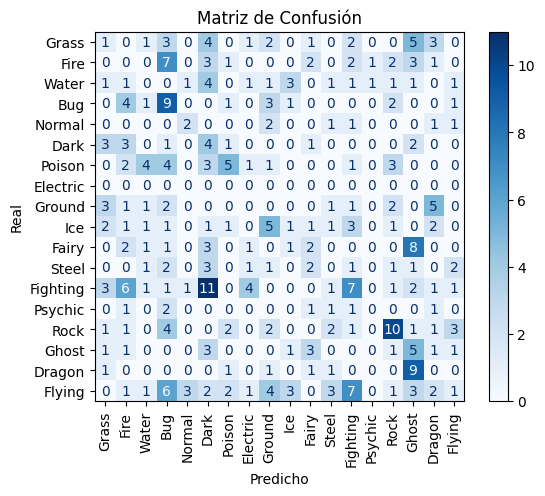

In [ ]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mnb, display_labels=tipos_pokemon)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Matriz de Confusión")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Mirando la matriz podemos decir que en la diagonal acierta con algunos valores, sin embargo ciertas categorías tienen muchos registros con malas predicciones como por ejemplo, predijo 11 con Dark y eran Fighting, 9 con Ghost y eran Dragon.

Si comparamos el accuracy del test de 20% y el test de 30% vemos que el de 20% de prueba es mejor ya que es 0.15 y el de 30% es 0.13.

Sin embargo, ambos modelos son malos ya que en ambos casos menos del 20% de los registros fueron categorizados correctamente.

## k-NN

vamos a usar la misma discretización que en naive Bayes

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_MN, y_MN, test_size=0.2, random_state=12)

In [ ]:
# Inicializar el clasificador KNN
knn_model_GSCV = KNeighborsClassifier()

# Definir los parámetros a ajustar
parametros_grid = {'n_neighbors':  range(1, 15, 2),
                   'p':[1,2,3],
                   'weights': ['uniform', 'distance'],
                   }

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(estimator = knn_model_GSCV,
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

In [ ]:
# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
mejor_modelo = grid_search.best_estimator_
# Realizar predicciones en el conjunto de prueba
pred = mejor_modelo.predict(X_test)

Mejores hiperparámetros: {'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}


In [ ]:
# Calcular métricas
precision = precision_score(y_test, pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred, average='weighted')
cm_mnb = metrics.confusion_matrix(y_test, pred)

# Crear una tabla con las métricas
metricas = pd.DataFrame({
    'Precision': [precision_mnb],
    'Accuracy': [accuracy_mnb],
    'Recall': [recall_mnb]
})

print(metricas)

   Precision  Accuracy   Recall
0   0.143663   0.13467  0.13467


<Figure size 800x600 with 0 Axes>

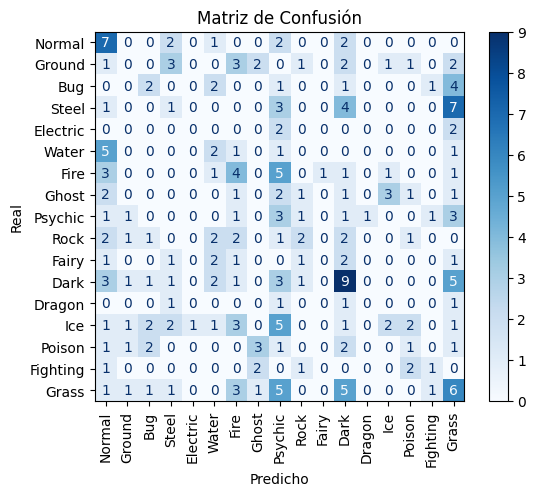

In [ ]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mnb, display_labels=etiquetas)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Matriz de Confusión")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La exactitud del modelo es bastante mala ya que solo clasifica correctamente el 14% de mis datos de prueba (Accuracy).

Como conclusión general, podemos decir que en nuestro caso y teniendo en cuenta que el data set está desbalanceado, es mejor dividir el test y train en 80-20 en todos los casos. El modelo que mejor accuracy nos dió es el arbol de clasificación.

Sin embargo ninguno supera el 20%, aún haciendo un ajuste de hiperparámetros con Grid Search.